# Threshold optimization 

Jukes Liu

## Import packages and set paths

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import matplotlib.pylab as pl
import numpy.ma as ma
import datetime
import math
import scipy.optimize
import time
import random

In [2]:
basepath = '/media/jukes/jukes1/'
sg_path = '/home/jukes/Documents/Sample_glaciers/'

## Read in analysis dates for manual and automated delinations, convert to datetime objs

In [3]:
# #read in manual image dates
# manual_df= pd.read_csv(basepath+'Manual/manual_tpos.csv', sep=',', dtype=str, header=0)
# manual_df = manual_df.dropna()
# manual_df.drop_duplicates(subset=['BoxID','datetimes'])
# print(manual_df.shape)
# manual_df.head()

In [4]:
# #Read in datetags csv as datetime_df
# automated_df = pd.read_csv(sg_path+'imgdates.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])
# print(automated_df.shape)
# automated_df.head()

## Find overlaps and select 90% for training, 10% for testing

In [5]:
# overlap_df = manual_df.merge(automated_df, how='inner', on=['datetimes'])
# overlap_df = overlap_df.drop(['Line_x', 'Line_y'], axis=1)
# overlap_df = overlap_df.drop_duplicates(['BoxID','datetimes'])
# overlap_df = overlap_df.sort_values(by=['BoxID','datetimes'], ascending=True)
# overlap_df.shape

In [6]:
# dates = []
# for idx, row in overlap_df.iterrows():
#     dateID = str(row['BoxID'])+','+str(row['datetimes']+','+str(row['Scene']))
#     dates.append(dateID)
# # print(date_IDs)

### Select 90% for training

In [7]:
# N = len(dates); print(N)

# #pick a random sample of dates for training
# train_dates = random.sample(dates, int(N*0.9))
# print(len(train_dates))
# # print(train_dates)

# #grab remaining for testing
# test_dates = []
# for date in dates:
#     if date not in train_dates:
#         test_dates.append(date)
# print(len(test_dates))
# # print(test_dates)

# #Check that they don't overlap, should return empty
# print(len(train_dates)+len(test_dates)); print(set(train_dates).intersection(test_dates))

In [8]:
# boxes = []; imgdates = []; scenes = []

# for td in train_dates:
#     BoxID, imgdate, scene = td.split(',')
#     boxes.append(BoxID); imgdates.append(imgdate); scenes.append(scene)

# train_df = pd.DataFrame(list(zip(boxes, imgdates, scenes)), columns=['BoxID', 'datetime', 'Scene'])
# train_df.head()

In [9]:
# #export to csv and text
# train_df.to_csv(basepath+'/Manual/train.csv', sep=',', index=False, header=False)
# train_df.to_csv(basepath+'/Manual/train.txt', sep=' ', index=False, header=False)

### Grab test dates

In [10]:
# boxes = []; imgdates = []; scenes = []

# for td in test_dates:
#     BoxID, imgdate, scene = td.split(',')
#     boxes.append(BoxID); imgdates.append(imgdate); scenes.append(scene)

# test_df = pd.DataFrame(list(zip(boxes, imgdates, scenes)), columns=['BoxID', 'datetime', 'Scene'])
# # test_df.head()
# #export to csv and text
# test_df.to_csv(basepath+'/Manual/test.csv', sep=',', index=False, header=False)
# test_df.to_csv(basepath+'/Manual/test.txt', sep=' ', index=False, header=False)

## Run the optimization

    scipy.optimize.fmin(func, x0, args=(), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None)[source]

Minimize a function using the downhill simplex algorithm.
This algorithm only uses function values, not derivatives or second derivatives.

Parameters
   - funccallable func(x,*args)
The objective function to be minimized.

   - x0ndarray
Initial guess.

Returns
   - xoptndarray
Parameter that minimizes function.

   - foptfloat
Value of function at minimum: fopt = func(xopt).

   - iterint
Number of iterations performed.

   - funcallsint
Number of function calls made.

   - warnflagint
1 : Maximum number of function evaluations made. 2 : Maximum number of iterations reached.

    -allvecslist
Solution at each iteration.

In [11]:
#IMPORT THE OBJECTIVE FUNCTION
os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import objective_func, calc_theta

In [26]:
#create the thresholds to input into the objective function
base_size_thresh = 0.66; base_mod_thresh = 0.7; base_arg_thresh = 0.47;
thresh_range = 0.05; step=0.01;
# size_guesses = np.arange(base_size_thresh-thresh_range-step, base_size_thresh+thresh_range, step)
size_guesses = np.arange(0.6, 0.65, step)
# mod_guesses = np.arange(base_mod_thresh-thresh_range, base_mod_thresh+thresh_range, step)
mod_guesses = [base_mod_thresh]
arg_guesses = np.arange(base_arg_thresh-thresh_range-step, base_arg_thresh+thresh_range, step)
# display the threshold guesses
print(size_guesses); print(mod_guesses); print(arg_guesses)

[0.6  0.61 0.62 0.63 0.64 0.65]
[0.7]
[0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52]


In [27]:
# create list of thresholding orders to test
# orders = ['_AMS', '_ASM', '_MAS', '_MSA', '_MSA', '_SAM', '_SMA']
orders = ['_MSA']
n_iter = len(orders)*len(size_guesses)*len(mod_guesses)*len(arg_guesses)
print(n_iter, 'iterations'); print(n_iter*20/60, "max hours to run")

72 iterations
24.0 max hours to run


### Test the thresholds:

In [28]:
import subprocess
import pandas as pd; import numpy as np
import time

# BoxIDs = " ".join(['001', '002', '120', '174', '259']); print(IDs)
start_time = time.time() #start recording time

slist = []; mlist = []; alist = []; orderlist = []; thetalist = []; runtimes = []; #store run results

iter_count = 0
for order in orders:
    for s in size_guesses:
        for m in mod_guesses:
            for a in arg_guesses:
                t0 = time.time() # start recording time for each run
                # make sure precision and format is correct for the thresholds
                s = float("{0:.3f}".format(s)); m = float("{0:.3f}".format(m)); a = float("{0:.3f}".format(a));
                print(order[1:4], s, m, a)
                #append the thresholds and order to lists
                slist.append(s); mlist.append(m); alist.append(a); orderlist.append(order[1:4]) 
                
                #run objective function calculation
                theta = objective_func(s, m, a, order, 'train'); print(theta); thetalist.append(theta)

                runtime = time.time() - t0; runtimes.append(runtime) # calculate run time and store
                print("Iteration run time: %s seconds " % runtime) #print run time for each iteration
                
                iter_count = iter_count+1
                print("Progress: "+str(iter_count/n_iter*100)+" %")
        
print("Total time elapsed: --- %s seconds ---" % (time.time() - start_time)) #Print total time elapsed

MSA 0.6 0.7 0.41
26.069729642811836
Iteration run time: 641.5764005184174 seconds 
Progress: 1.3888888888888888 %
MSA 0.6 0.7 0.42
26.29395248300832
Iteration run time: 633.8514518737793 seconds 
Progress: 2.7777777777777777 %
MSA 0.6 0.7 0.43
26.196357447174023
Iteration run time: 620.4384689331055 seconds 
Progress: 4.166666666666666 %
MSA 0.6 0.7 0.44
25.70150716543253
Iteration run time: 602.3919389247894 seconds 
Progress: 5.555555555555555 %
MSA 0.6 0.7 0.45
25.625206459760015
Iteration run time: 593.5261583328247 seconds 
Progress: 6.944444444444445 %
MSA 0.6 0.7 0.46
25.50368602827768
Iteration run time: 577.6171350479126 seconds 
Progress: 8.333333333333332 %
MSA 0.6 0.7 0.47
25.887579944427365
Iteration run time: 571.4732291698456 seconds 
Progress: 9.722222222222223 %
MSA 0.6 0.7 0.48
25.14252606969786
Iteration run time: 561.368674993515 seconds 
Progress: 11.11111111111111 %
MSA 0.6 0.7 0.49
24.97469874321461
Iteration run time: 555.0175898075104 seconds 
Progress: 12.5 %


In [29]:
optimization_df = pd.DataFrame(list(zip(thetalist, orderlist, slist, mlist, alist, runtimes)), 
                               columns=['Theta', 'Order', 'Size_thresh', 'Mod_thresh', 'Arg_thresh','run_time'])
optimization_df

,Theta,Order,Size_thresh,Mod_thresh,Arg_thresh,run_time
0,26.069730,MSA,0.60,0.7,0.41,641.576401
1,26.293952,MSA,0.60,0.7,0.42,633.851452
2,26.196357,MSA,0.60,0.7,0.43,620.438469
3,25.701507,MSA,0.60,0.7,0.44,602.391939
4,25.625206,MSA,0.60,0.7,0.45,593.526158
5,25.503686,MSA,0.60,0.7,0.46,577.617135
6,25.887580,MSA,0.60,0.7,0.47,571.473229
7,25.142526,MSA,0.60,0.7,0.48,561.368675
8,24.974699,MSA,0.60,0.7,0.49,555.017590
9,24.894802,MSA,0.60,0.7,0.50,544.113187


In [45]:
#print thresholds that yielded the minimum misfit
optimization_df[optimization_df['Theta'] == np.min(optimization_df['Theta'])]

,Unnamed: 0,Theta,Order,Size_thresh,Mod_thresh,Arg_thresh,run_time
77,77,24.683407,MSA,0.71,0.7,0.46,596.806232


In [31]:
#write to csv
optimization_df.to_csv(sg_path+'optimizationresults_SA_train_2.csv', sep=',')

# Visualize optimization results

Results from calculating mistfits between automated and manual delineations based on different thresholds used for filtering the WTMM lines. The two thresholds shown here are the size (length) threshold and the mod (gradient value) threshold, which are percentages of the maximum size/mod. So ideally, for 1 parameter (one threshold), the results should look like a parabola. For two 2 parameters like used here, one can visualize it in 3D. 

In [3]:
#plot results
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

#activate interactive widgets for plots:
%matplotlib notebook

# path = '/Users/julialiu/Documents/BSU/EGG/'

In [10]:
df1 = pd.read_csv(sg_path+'optimizationresults_order.csv', sep=',')
df2 = pd.read_csv(sg_path+'optimizationresults_order2.csv', sep=',')
# df3 = pd.read_csv(sg_path+'optimizationresults_SA_3.csv', sep=',')
# # df4 = pd.read_csv(sg_path+'optimizationresults_4.csv', sep=',')
# optimization_df = pd.concat([df1, df2, df3])
optimization_df = pd.concat([df1, df2])
# optimization_df = pd.read_csv(sg_path+'optimizationresults_SA_train_all.csv', sep=',')
optimization_df.head(10)

,Unnamed: 0,Theta,Order,Size_thresh,Mod_thresh,Arg_thresh,run_time
0,0,26.282047,AMS,0.5,0.5,0.1,250.426890
1,1,26.282047,AMS,0.5,0.5,0.2,249.570597
2,2,26.282047,AMS,0.5,0.5,0.3,228.628392
3,3,26.282047,AMS,0.5,0.5,0.4,220.598381
4,4,26.424514,AMS,0.5,0.5,0.5,183.725648
5,5,26.424514,AMS,0.5,0.6,0.1,207.791198
6,6,26.424514,AMS,0.5,0.6,0.2,192.693135
7,7,26.503489,AMS,0.5,0.6,0.3,201.553125
8,8,26.503489,AMS,0.5,0.6,0.4,180.051195
9,9,26.503489,AMS,0.5,0.6,0.5,173.390613


In [30]:
# optimization_df.to_csv(sg_path+'optimizationresults_SA_total.csv', sep=',')

Separate by Order

In [21]:
# order = 'MSA'
# order_df = optimization_df[optimization_df['Order']==order]
# # order_df

# x = order_df['Size_thresh']
# y = order_df['Mod_thresh']
# z = order_df['Arg_thresh']
# theta = order_df['Theta']


In [22]:
# # 3 parameters
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(1,1,1, projection='3d')

# # ax.plot_trisurf(triang, z, cmap='hot') # plot the surface over the mesh
# plot = ax.scatter(x,y,z, marker='o', s=120, c=theta, cmap='magma') # plot the points
# ax.view_init(elev=20, azim=45) # set initial view angle
# fig.colorbar(plot)

# ax.set_xlabel('Size threshold')
# ax.set_ylabel('Mod threshold')
# ax.set_zlabel('Arg threshold')
# plt.show()

In [5]:
optimization_df = optimization_df[optimization_df['Size_thresh'] > 0.63]
x = optimization_df['Size_thresh']
y = optimization_df['Arg_thresh']
z = optimization_df['Theta']

<IPython.core.display.Javascript object>


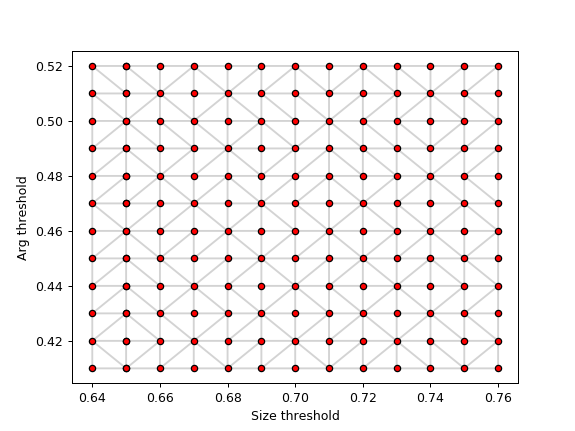

In [6]:
triang = mtri.Triangulation(x, y)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.triplot(triang, c="#D3D3D3", marker='.', markerfacecolor="r", markeredgecolor="black", markersize=10)
ax.set_xlabel('Size threshold')
ax.set_ylabel('Arg threshold')
plt.show()

<IPython.core.display.Javascript object>


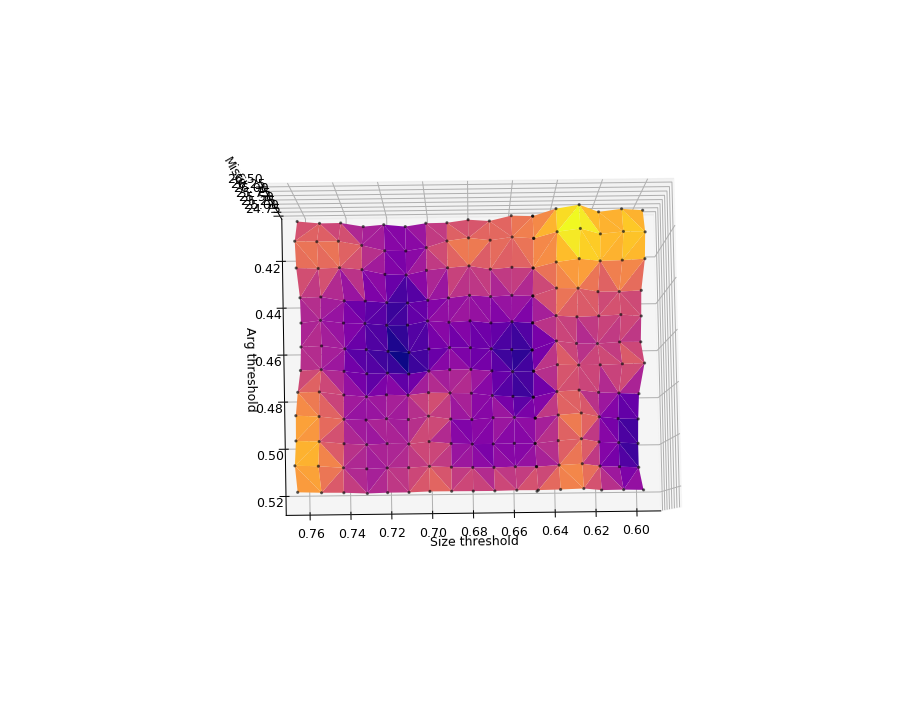

In [36]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')

ax.plot_trisurf(triang, z, cmap='plasma') # plot the surface over the mesh
ax.scatter(x,y,z, marker='.', s=10, c="k", alpha=0.5) # plot the points
ax.view_init(elev=20, azim=45) # set initial view angle

ax.set_xlabel('Size threshold')
ax.set_ylabel('Arg threshold')
ax.set_zlabel('Misfit')
plt.show()

<IPython.core.display.Javascript object>


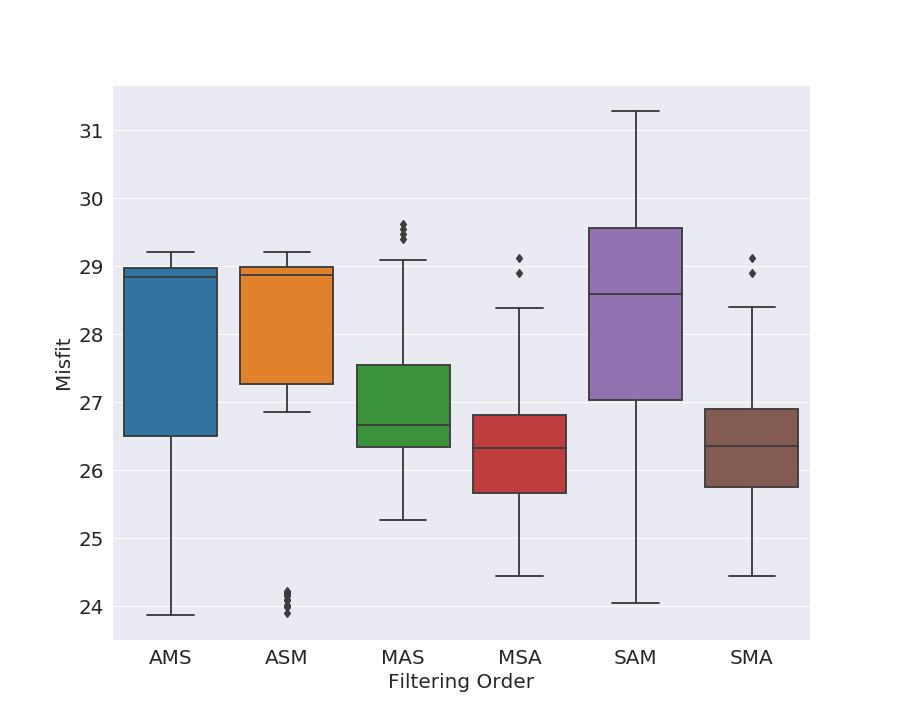

In [12]:
# order boxplot
df1 = pd.read_csv(sg_path+'optimizationresults_order.csv', sep=',')
df2 = pd.read_csv(sg_path+'optimizationresults_order2.csv', sep=',')
optimization_df = pd.concat([df1, df2])

import seaborn as sns

plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
ax = sns.boxplot(x = 'Order', y = 'Theta', data=optimization_df)
plt.ylabel('Misfit', fontsize=16); plt.xlabel('Filtering Order', fontsize=16)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
plt.savefig(sg_path+'Misfit_by_order.png', dpi=200)
plt.show()

In [29]:
orderdf = optimization_df[optimization_df['Order']=='MAS']
print(np.median(list(orderdf.Theta)))
print(np.average(list(orderdf.Theta)))

26.670178760579173
26.939659527254182


### Contour plot

In [7]:
# import sys
# !{sys.executable} -m pip install plotly

import plotly.graph_objects as go
import psutil

In [46]:
fs = 20
contour_set = dict(showlabels= True, labelfont=dict(size=14, color='black'))
colorbar_set = dict(title='Misfit', titleside='right', titlefont=dict(size=fs), tickfont=dict(size=fs))

fig = go.Figure(data=go.Contour(z=z, x=x, y=y, contours=contour_set, colorbar=colorbar_set, ncontours=17))
fig.update_xaxes(title='C<sub>L</sub>', titlefont=dict(size=fs), tickfont=dict(size=fs))
fig.update_yaxes(title='C<sub>A</sub>', titlefont=dict(size=fs), tickfont=dict(size=fs))
fig.show()

## Cross-validation

Using optimal thresholds identified: size=0.71, mod=0.7, arg=0.46.

In [48]:
#print thresholds that yielded the minimum misfit
minimum_df = optimization_df[optimization_df['Theta'] == np.min(optimization_df['Theta'])]
minimum_df

,Unnamed: 0,Theta,Order,Size_thresh,Mod_thresh,Arg_thresh,run_time
77,77,24.683407,MSA,0.71,0.7,0.46,596.806232


In [59]:
# final thresholds
# s=0.71; m=0.7; a=0.46; order='_MSA'
s=list(minimum_df.Size_thresh)[0]; m=list(minimum_df.Mod_thresh)[0]; a=list(minimum_df.Arg_thresh)[0]; order='_MSA'

sfinal = float("{0:.3f}".format(s)); mfinal = float("{0:.3f}".format(m)); afinal = float("{0:.3f}".format(a));

t0 = time.time() # start recording time
                
#run objective function calculation
theta = objective_func(sfinal, mfinal, afinal, order, 'test'); print(theta);
runtime = time.time() - t0; print("Run time: %s seconds " % runtime) #print run time

24.656200524397935
Run time: 454.958398103714 seconds 
